In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from gnuradio import channels, gr, blocks, analog, digital
import datetime as dt
import sigmf
from sigmf import SigMFFile
from signals.comms import *

## Global Variables

In [10]:
# Channel parameters
snr = 13
noise_voltage = 10**(-snr/20)
nSamples = int(1e3)
# Modulation parameteres
sampRate = 200e3
sampsPerSym = 2
symRate = sampRate / sampsPerSym
# Metadata setup
dataDir = 'data/'
filename = 'dataset'
# Create directory if it doesn't exist
Path(dataDir).mkdir(parents=True, exist_ok=True)
# Open and close the data file to create it if it doesn't exist. This is
# necessary for the SigMFFile object below
datafile = open(dataDir+filename+'.sigmf-data','w+')
datafile.close()
meta = SigMFFile(
  data_file=dataDir+filename+'.sigmf-data',
  global_info={
    SigMFFile.DATATYPE_KEY: 'cf32_le',
    SigMFFile.SAMPLE_RATE_KEY: sampRate,
    SigMFFile.AUTHOR_KEY: 'Shane Flandermeyer, shane.flandermeyer@ou.edu',
    SigMFFile.DESCRIPTION_KEY: 'Synthetic RF dataset for machine learning',
    SigMFFile.VERSION_KEY: sigmf.__version__,
  }
)


## Now do it in a loop

In [11]:
# Number of vectors per modulation class
nVecClass = 50
# Number of samples per vector
nSamplesVec = 128
data = np.zeros((0,), dtype=np.complex64)
# A running count of the number of samples produced
nSamplesProduced = 0
# A running cound of the number of vectors produced
nIterations = 0
# Loop through all the modulation types defined in this list
modulations = [bpsk, qpsk]
for modulation in modulations:
    if isinstance(modulation, type):
        # If the current element is a type object, create a new instance of that
        # class
        sig = modulation()
    else:
        # Otherwise we can just use the object directly
        sig = modulation
    # Create and run the flowgraph
    # Flowgraph object
    tb = gr.top_block()
    # Draw 8-bit sequences from a uniform distribution
    src = analog.random_uniform_source_b(0, 256, 0)
    # Symbol constellation
    constellation = sig.constellation
    # Constellation modulator
    mod = digital.generic_mod(
        constellation=constellation,
        differential=False,
        samples_per_symbol=2,
        pre_diff_code=True,
        excess_bw=0.35,
        verbose=False,
        log=False,
        truncate=False)
    channel = channels.channel_model(
        noise_voltage=noise_voltage, taps=[1])
    # Head block to limit the number of samples
    head = blocks.head(gr.sizeof_char, nSamples)
    # Vector sink
    sink = blocks.vector_sink_c()
    tb.connect(src, head, mod, channel, sink)
    # Generate nVecClass vectors of nSamplesVec samples each
    for iVec in range(nVecClass):
        head.reset()
        sink.reset()
        tb.run()
        result = sink.data()
        # Normalize the energy to stay consistent with different modulations
        energy = np.sum(np.abs(result)**2)
        data = np.append(data, np.array(result/energy, dtype=np.complex64))
        # Create the metadata dictionary
        detail = sig.detail
        metaDict = {
            SigMFFile.DATETIME_KEY: dt.datetime.utcnow().isoformat()+'Z'}
        metaDict[sig.DETAIL_KEY] = detail.dict()
        meta.add_annotation(nSamplesProduced, len(result), metadata=metaDict)
        nSamplesProduced += sink.nitems_read(0)
        nIterations += 1

print(f'Created {nIterations} sample vectors')
# Check for mistakes and write to disk
data.tofile(dataDir+filename+'.sigmf-data')
assert meta.validate()
meta.tofile(dataDir+filename)  # extension is optional


Created 100 sample vectors


## Post Processing

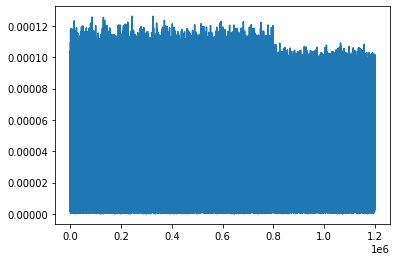

In [12]:
test = np.fromfile(dataDir+filename+'.sigmf-data', dtype=np.complex64)
plt.plot(np.abs(test))
plt.show()